#### Tóm tắt các bước chính

1. Khởi tạo môi trường CartPole
2. Xây dựng mô hình A2C với 2 mạng: mạng Actor và mạng Critic (mỗi mạng gồm 2 lớp Dense)
3. Huấn luyện mô hình:
    - Với mỗi episode:
        - Khởi tạo trạng thái và điểm số
        - Với mỗi bước trong episode:
            - Lấy hành động từ mạng Actor
            - Thực hiện hành động, nhận lại trạng thái tiếp theo và điểm số
            - Tính reward cho hành động
            - Cập nhật mô hình với hành động, reward và trạng thái tiếp theo
            - Cập nhật điểm số
        - Lưu điểm số của episode
        - Vẽ biểu đồ điểm số
        - Nếu điểm số trung bình của 10 episode gần nhất lớn hơn 490 thì dừng huấn luyện
4. Lưu mô hình sau mỗi 50 episode
5. Đóng môi trường CartPole
6. Gọi hàm CartPoleCrossEntropy với số episode mặc định là 20
7. Kết quả: sau 20 episode, mô hình chưa học được cách chơi tốt, điểm số không tăng lên nhiều
    - Cần tăng số episode để mô hình học được cách chơi tốt hơn
    - Cần tinh chỉnh các siêu tham số khác để mô hình học tốt hơn
    - Cần thử các mô hình khác để so sánh hiệu suất

#### Import các thư viện cần thiết

In [1]:
import sys
import gym
import pylab
import numpy as np
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import Callback
from collections import deque
from tqdm import tqdm
from tqdm.keras import TqdmCallback

#### Define hàm cross_entropy_loss

In [2]:
import tensorflow as tf

def cross_entropy_loss(y_true, y_pred):
    val = y_true * tf.math.log(y_pred)
    print('val = ', val)
    # Tính tổng các phần tử theo hàng
    return tf.reduce_sum(-val, axis=1)

y_true = tf.constant([[1, 0, 0]], dtype=tf.float32)
y_pred = tf.constant([[0.1, 0.8, 0.1]], dtype=tf.float32)
loss = cross_entropy_loss(y_true, y_pred)
print('loss = ', loss)

val =  tf.Tensor([[-2.3025851 -0.        -0.       ]], shape=(1, 3), dtype=float32)
loss =  tf.Tensor([2.3025851], shape=(1,), dtype=float32)


#### Define A2C agent

A2C (Advantage Actor-Critic) là một thuật toán huấn luyện mô hình học tăng cường, kết hợp giữa Actor-Critic và Advantage Learning. Mô hình A2C bao gồm 2 mạng: mạng Actor và mạng Critic. 
- Mạng `Actor`:
    + Actor là phần của mô hình học tăng cường chịu trách nhiệm đưa ra các hành động dựa trên trạng thái hiện tại của môi trường.
    + Nhiệm vụ của Actor là tối ưu hóa hành động để đạt được phần thưởng lớn nhất.
    + Actor thường được biểu diễn bằng một hàm chính sách (policy) hoặc mạng nơ-ron.
    + Hàm mất mát của mạng Actor sẽ được tính bằng cross entropy loss giữa xác suất dự đoán và hành động thực tế.

- Mạng `Critic`:
    + Critic là phần của mô hình học tăng cường đánh giá và đưa ra đánh giá về hiệu suất của Actor.
    + Critic ước tính giá trị của trạng thái hiện tại hoặc cặp trạng thái-hành động.
    + Nhiệm vụ của Critic là cung cấp thông tin phản hồi cho Actor để cải thiện hành động.
    + Critic thường được biểu diễn bằng một hàm giá trị (value function) hoặc mạng nơ-ron.
    + Hàm mất mát của mạng Critic sẽ được tính bằng Mean Squared Error giữa giá trị ước lượng và giá trị thực tế.



In [3]:
class LossHistory(Callback):
    '''Dùng để lưu lại loss và val_loss sau mỗi batch'''
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

In [4]:
# A2C(Advantage Actor-Critic) agent for the Cartpole
class A2CAgent:
    def __init__(self, state_size, action_size):
        # Nếu render = True thì sẽ hiển thị Cartpole trên màn hình
        self.render = True
        # Nếu load_model = True thì sẽ load model đã được train trước đó để tiếp tục train
        self.load_model = False
        # Lấy kích thước của state và action
        self.state_size = state_size
        self.action_size = action_size
        # Kích thước của value
        self.value_size = 1

        # Hyperparameter của A2C agent (dùng để train model)
        self.discount_factor = 0.99
        # learning rate của actor và critic
        ## 0.03 0.005 - learning rate for half faster
        self.actor_lr = 0.03
        self.critic_lr = 0.005

        # history: lưu lại thông tin của môi trường sau mỗi episode
        self.history = {
            'actor': LossHistory(),
            'critic': LossHistory()
        }

        # Build actor and critic models
        self.actor = self.build_actor()
        self.critic = self.build_critic()

        # Nếu load_model = True thì load model đã được train trước đó
        if self.load_model:
            self.actor.load_weights("cartpole_actor.weights.h5")
            self.critic.load_weights("cartpole_critic.weights.h5")
    
    def ce_custom_loss(self, y_true, y_pred):
        '''
        Custom loss function for cross entropy loss
        '''
        val = tf.square(y_true) * tf.math.log(y_pred) + y_true
        return tf.reduce_sum(-val, -1)

    def cross_entropy_loss(self, y_true, y_pred):
        '''
        Cross entropy loss function: loss = - sum(y_true * log(y_pred))
        '''
        val = y_true * tf.math.log(y_pred)
        return tf.reduce_sum(-val, -1)

    # approximate policy and value using Neural Network
    # actor: state is input and probability of each action is output of model
    def build_actor(self):
        '''Actor model: Ước lượng xác suất của mỗi hành động có thể thực hiện được
        - Input: trạng thái của môi trường
        - Output: xác suất của mỗi hành động có thể thực hiện được
        '''

        # Sequential model: mô hình mạng nơ-ron tuần tự (các lớp nơ-ron được xếp chồng lên nhau)
        actor = Sequential()
        # Thêm lớp nơ-ron vào mô hình: 24 nơ-ron, hàm kích hoạt relu, kernel_initializer=he_uniform
        actor.add(Dense(24, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        # Thêm lớp nơ-ron vào mô hình: self.action_size nơ-ron, hàm kích hoạt softmax, kernel_initializer=he_uniform
        actor.add(Dense(self.action_size, activation='softmax', kernel_initializer='he_uniform'))
        # print("ACTOR SUMMARY")
        # actor.summary()

        # Tính độ chính xác của mô hình
        # TopKCategoricalAccuracy: Tính độ chính xác của mô hình dựa trên top-k lớp có xác suất cao nhất
        # k=1: chỉ xem xác suất lớn nhất
        acc = tf.keras.metrics.TopKCategoricalAccuracy(k=1, name="top_k_categorical_accuracy", dtype=None)

        # Using CROSS ENTROPY LOSS
        # Biên dịch mô hình, sử dụng hàm mất mát cross_entropy_loss, tối ưu hóa bằng Adam, đánh giá bằng độ chính xác
        actor.compile(loss=self.cross_entropy_loss, optimizer=Adam(learning_rate=self.critic_lr), metrics=[acc])
        
        return actor

    # critic: state is input and value of state is output of model
    def build_critic(self):
        '''Critic model: Ước lượng giá trị của trạng thái
        - Input: trạng thái của môi trường
        - Output: giá trị của trạng thái đó
        '''

        # Sequential model: mô hình mạng nơ-ron tuần tự (các lớp nơ-ron được xếp chồng lên nhau)
        critic = Sequential()
        # Thêm lớp nơ-ron vào mô hình: 24 nơ-ron, hàm kích hoạt relu, kernel_initializer=he_uniform
        critic.add(Dense(24, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        # Thêm lớp nơ-ron vào mô hình: self.value_size nơ-ron, hàm kích hoạt linear, kernel_initializer=he_uniform
        critic.add(Dense(self.value_size, activation='linear', kernel_initializer='he_uniform'))
        # print("CRITIC SUMMARY")
        # critic.summary()

        # Biên dịch mô hình, sử dụng hàm mất mát mse, tối ưu hóa bằng Adam
        critic.compile(loss="mse", optimizer=Adam(learning_rate=self.critic_lr))
        
        return critic

    # using the output of policy network, pick action stochastically
    def get_action(self, state):
        '''Chọn hành động dựa trên xác suất của mỗi hành động
        - Input: trạng thái của môi trường
        - Output: hành động được chọn (0: left, 1: right)
        '''
        # Dự đoán xác suất của mỗi hành động dựa trên trạng thái hiện tại
        policy = self.actor.predict(state, verbose=0, batch_size=1).flatten()
        # Chọn hành động dựa trên xác suất đã dự đoán
        return np.random.choice(self.action_size, 1, p=policy)[0]

    # update policy network every episode
    def train_model(self, state, action, reward, next_state, done, episode = 1, action_index = 1):

        # Tạo mảng target và advantages, kích thước (1, self.value_size) và (1, self.action_size)
        # target: giá trị mục tiêu, advantages: lợi ích của việc thực hiện hành động
        target = np.zeros((1, self.value_size))
        advantages = np.zeros((1, self.action_size))

        # Tính giá trị của trạng thái hiện tại và trạng thái tiếp theo
        value = self.critic.predict(state, verbose=0)[0][0]
        next_value = self.critic.predict(next_state, verbose=0)[0][0]

        # Nếu trạng thái hiện tại là trạng thái cuối cùng, giá trị target sẽ là reward
        if done:
            advantages[0][action] = reward - value
            target[0][0] = reward

        # Ngược lại, tính advantages và giá trị target dựa trên giá trị của trạng thái tiếp theo
        else:
            advantages[0][action] = reward + self.discount_factor * (next_value) - value
            target[0][0] = reward + self.discount_factor * next_value

        # In ra thông tin để debug
        # print("advantages", advantages, "target", target, "adv type", type(advantages), advantages.shape)
        #advantages advantages[np.where(advantages==np.max(advantages))] = 1
        # Chuẩn hóa advantages
        advantages = (advantages - np.min(advantages))/np.ptp(advantages)
        # print("advantages", advantages)

        # Train actor và critic model, verbose=0: không in ra quá trình train
        self.actor.fit(state, advantages, epochs=1, verbose=0, callbacks=[self.history['actor']])
        self.critic.fit(state, target, epochs=1, verbose=0, callbacks=[self.history['critic']])

        # In ra thông tin để debug
        print(f"{episode}.{action_index} {'left' if action == 0 else 'right'}, \t actor_loss = {self.history['actor'].losses[-1]}, \t critic_loss = {self.history['critic'].losses[-1]}")

        

#### Huấn luyện mô hình A2C

In [119]:
def CartPoleCrossEntropy(EPISODES=1):
    # Khởi tạo môi trường CartPole với render_mode="human"
    env = gym.make('CartPole-v1', render_mode="human")
    
    # Lấy kích thước của state và action
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n
    print("state size: ", state_size, "action size: ", action_size)
    
    # Khởi tạo agent A2C
    agent = A2CAgent(state_size, action_size)

    # Khởi tạo biến lưu điểm số và số episode
    scores, episodes, action_count = [], [], []
    scores_deque = deque(maxlen=100)

    # Duyệt qua các episode
    for e in range(1, EPISODES+1):
        print(f">>>>>>>>>>>>>>>>>> Episode {e} >>>>>>>>>>>>>>>>>> ")
        action_index = 1
        done = False
        # Reset điểm số, trạng thái tại mỗi episode
        score = 0
        state, _ = env.reset()
        state = np.reshape(state, [1, state_size])
        
        # Duyệt qua các bước trong mỗi episode
        while not done:
            if agent.render:
                env.render()

            # Lấy 1 action từ agent dựa vào trạng thái hiện tại
            action = agent.get_action(state)
            action_index += 1
            # Thực hiện action, nhận lại các thông số mới
            next_state, reward, done, info, _ = env.step(action)
            next_state = np.reshape(next_state, [1, state_size])
            # Nếu game chưa kết thúc, thì reward = 1, ngược lại reward = -100
            reward = reward if not done or score == 499 else -100

            # Train model với các thông số mới
            agent.train_model(state, action, reward, next_state, done, e, action_index)
            # Cập nhật điểm số và trạng thái mới
            score += reward
            state = next_state

            # Nếu game kết thúc, in ra điểm số và số episode
            if done:
                # Tính score: nếu score = 500 thì score = 500, ngược lại score = score + 100
                score = score if score == 500.0 else score + 100
                # Thêm điểm số vào mảng scores và scores_deque
                scores.append(score)
                scores_deque.append(score)
                action_count.append(action_index)

                # Vẽ biểu đồ điểm số theo số episode và lưu vào file cartpole_a2c.png
                episodes.append(e)
                pylab.plot(episodes, scores, 'b')
                pylab.plot(episodes, action_count, 'r')
                pylab.xlabel("Episodes")
                pylab.ylabel("Values")
                pylab.title("Cartpole with A2C")
                pylab.grid(True)
                pylab.legend(["Scores", "Number of actions"])
                pylab.savefig("cartpole_a2c.png")
                # pylab.show()
                print("episode:", e, "  score:", score)

                # Nếu trung bình điểm số của 10 episode gần nhất > 490 thì dừng chương trình
                if np.mean(scores[-min(10, len(scores)):]) > 490:
                    sys.exit()
        
        # Lưu model sau mỗi 50 episode
        if e % 50 == 0:
            print("saving model")
            agent.actor.save_weights("cartpole_actor.weights.h5")
            agent.critic.save_weights("cartpole_critic.weights.h5")
    
    # Đóng môi trường
    env.close()

    return scores, episodes, action_count

#### Test mô hình với EPISODES = 2

In [120]:
scores, episodes, action_count = CartPoleCrossEntropy(2)

state size:  4 action size:  2
>>>>>>>>>>>>>>>>>> Episode 1 >>>>>>>>>>>>>>>>>> 
1.2 left, 	 actor_loss = 0.6772924661636353, 	 critic_loss = 1.3674603700637817
1.3 right, 	 actor_loss = 0.6088865399360657, 	 critic_loss = 0.6509321928024292
1.4 left, 	 actor_loss = 0.6596750020980835, 	 critic_loss = 1.4506869316101074
1.5 left, 	 actor_loss = 0.804108738899231, 	 critic_loss = 1.5382016897201538
1.6 left, 	 actor_loss = 0.9748058915138245, 	 critic_loss = 1.5746740102767944
1.7 right, 	 actor_loss = 0.3865540325641632, 	 critic_loss = 0.4855198562145233
1.8 right, 	 actor_loss = 0.4849991202354431, 	 critic_loss = 0.46582552790641785
1.9 right, 	 actor_loss = 0.5912333726882935, 	 critic_loss = 0.39661359786987305
1.10 left, 	 actor_loss = 0.650161862373352, 	 critic_loss = 1.9636505842208862
1.11 left, 	 actor_loss = 0.8305443525314331, 	 critic_loss = 1.8822400569915771
1.12 right, 	 actor_loss = 0.4478401839733124, 	 critic_loss = 0.3610648214817047
1.13 left, 	 actor_loss = 0.8581

KeyboardInterrupt: 

#### Test mô hình với EPISODES = 5

state size:  4 action size:  2
>>>>>>>>>>>>>>>>>> Episode 1 >>>>>>>>>>>>>>>>>> 
1.2 left, 	 actor_loss = 0.6867853403091431, 	 critic_loss = 0.6242625117301941
1.3 left, 	 actor_loss = 0.5179432034492493, 	 critic_loss = 0.6682844161987305
1.4 right, 	 actor_loss = 1.1744179725646973, 	 critic_loss = 1.2944037914276123
1.5 left, 	 actor_loss = 0.4941561818122864, 	 critic_loss = 0.7633584141731262
1.6 left, 	 actor_loss = 0.3716331124305725, 	 critic_loss = 0.8046325445175171
1.7 left, 	 actor_loss = 0.2710828185081482, 	 critic_loss = 0.8514975905418396
1.8 left, 	 actor_loss = 0.1893271803855896, 	 critic_loss = 0.9053071141242981
1.9 left, 	 actor_loss = 0.12555426359176636, 	 critic_loss = 0.9643566608428955
1.10 left, 	 actor_loss = 0.07874687761068344, 	 critic_loss = 1.0291597843170166
1.11 left, 	 actor_loss = 3.087311267852783, 	 critic_loss = 10134.0625
episode: 1   score: 9.0
>>>>>>>>>>>>>>>>>> Episode 2 >>>>>>>>>>>>>>>>>> 
2.2 right, 	 actor_loss = 0.7330152988433838, 	 cri

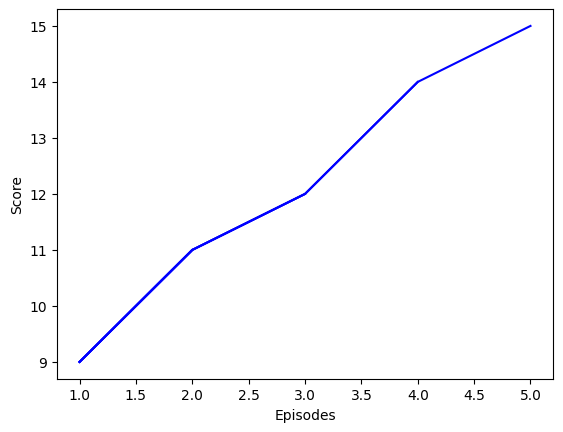

In [110]:
CartPoleCrossEntropy(EPISODES=5)

state size:  4 action size:  2
>>>>>>>>>>>>>>>>>> Episode 1 >>>>>>>>>>>>>>>>>> 
1.2 right, 	 actor_loss = 0.6664623618125916, 	 critic_loss = 1.092149019241333
1.3 right, 	 actor_loss = 0.5245360136032104, 	 critic_loss = 1.1644401550292969
1.4 left, 	 actor_loss = 1.1964058876037598, 	 critic_loss = 0.795113205909729
1.5 left, 	 actor_loss = 0.9023769497871399, 	 critic_loss = 0.8423277735710144
1.6 right, 	 actor_loss = 0.6423794627189636, 	 critic_loss = 1.2022935152053833
1.7 right, 	 actor_loss = 0.5431215167045593, 	 critic_loss = 1.3177257776260376
1.8 right, 	 actor_loss = 0.41705936193466187, 	 critic_loss = 1.3535815477371216
1.9 left, 	 actor_loss = 1.310780644416809, 	 critic_loss = 0.6242192387580872
1.10 left, 	 actor_loss = 1.0372765064239502, 	 critic_loss = 0.6130703091621399
1.11 right, 	 actor_loss = 0.5779252648353577, 	 critic_loss = 1.4917234182357788
1.12 right, 	 actor_loss = 0.4695100486278534, 	 critic_loss = 1.5475679636001587
1.13 right, 	 actor_loss = 0.379

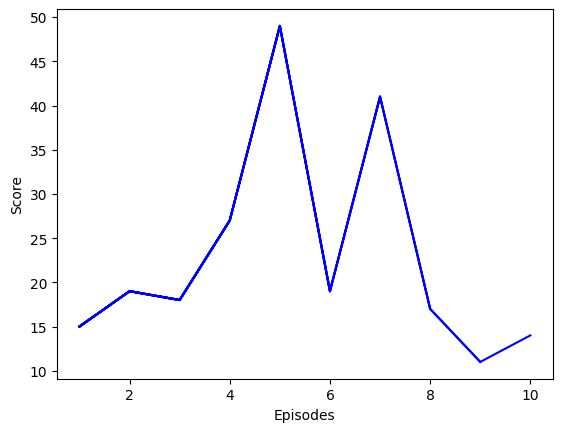

In [111]:
CartPoleCrossEntropy(EPISODES=10)

state size:  4 action size:  2
>>>>>>>>>>>>>>>>>> Episode 1 >>>>>>>>>>>>>>>>>> 
1.2 left, 	 actor_loss = 0.686679482460022, 	 critic_loss = 0.8511693477630615
1.3 left, 	 actor_loss = 0.46754854917526245, 	 critic_loss = 0.8594143986701965
1.4 right, 	 actor_loss = 1.3693816661834717, 	 critic_loss = 1.1456878185272217
1.5 right, 	 actor_loss = 0.9929679036140442, 	 critic_loss = 1.068266749382019
1.6 left, 	 actor_loss = 0.6554858088493347, 	 critic_loss = 0.9856033325195312
1.7 left, 	 actor_loss = 0.47596505284309387, 	 critic_loss = 1.0071964263916016
1.8 left, 	 actor_loss = 0.3250425159931183, 	 critic_loss = 1.0630266666412354
1.9 left, 	 actor_loss = 0.21779070794582367, 	 critic_loss = 1.1244080066680908
1.10 left, 	 actor_loss = 0.14231401681900024, 	 critic_loss = 1.1905931234359741
1.11 left, 	 actor_loss = 0.09037056565284729, 	 critic_loss = 1.2617462873458862
1.12 left, 	 actor_loss = 0.055712610483169556, 	 critic_loss = 1.3385475873947144
1.13 left, 	 actor_loss = 3.41

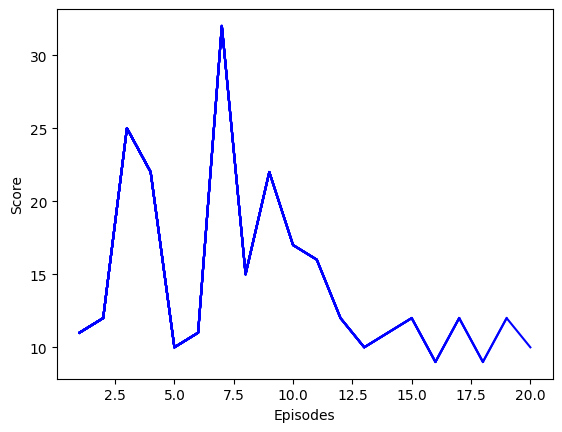

In [112]:
CartPoleCrossEntropy(EPISODES=20)

state size:  4 action size:  2
>>>>>>>>>>>>>>>>>> Episode 1 >>>>>>>>>>>>>>>>>> 
1.2 right, 	 actor_loss = 0.6734973192214966, 	 critic_loss = 1.7967603206634521
1.3 right, 	 actor_loss = 0.7068190574645996, 	 critic_loss = 1.8322253227233887
1.4 left, 	 actor_loss = 0.672958493232727, 	 critic_loss = 0.3862779140472412
1.5 right, 	 actor_loss = 0.6753894686698914, 	 critic_loss = 1.9501456022262573
1.6 right, 	 actor_loss = 0.7089506983757019, 	 critic_loss = 2.025289297103882
1.7 left, 	 actor_loss = 0.6667838096618652, 	 critic_loss = 0.32452985644340515
1.8 left, 	 actor_loss = 0.7095388770103455, 	 critic_loss = 0.3105933666229248
1.9 left, 	 actor_loss = 0.7487344741821289, 	 critic_loss = 0.2988473176956177
1.10 right, 	 actor_loss = 0.6124483942985535, 	 critic_loss = 2.276937961578369
1.11 right, 	 actor_loss = 0.6505023837089539, 	 critic_loss = 2.3521625995635986
1.12 left, 	 actor_loss = 0.6774529814720154, 	 critic_loss = 0.2557384967803955
1.13 left, 	 actor_loss = 0.73800

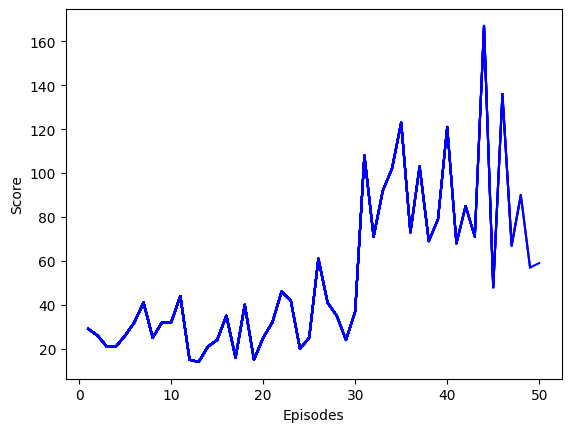

In [113]:
CartPoleCrossEntropy(EPISODES=50)